### Retrieving Data From the Hartland Observatory

This notebook looks at collecting from the Hartland observatory, using [geomagio](https://github.com/usgs/geomag-algorithms), provided by USGS. This data can then be used to compare with geomagnetic data, retrieved from Frongoch Farm.

1. Load relevant libraries.

In [6]:
import io

import geomagio
from obspy.core import UTCDateTime

import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
plt.rcParams.update({"font.size": 22})

2. Get the data recorded at Hartland, using geomagio tools. The data will be retrieved as a `.json` string.

In [2]:
input_factory = geomagio.edge.EdgeFactory()
timeseries = input_factory.get_timeseries(
    observatory = 'HAD',
    channels = ('H', 'E', 'Z', 'F'),
    type = 'variation',
    interval = 'minute',
        starttime = UTCDateTime('2016-03-20T00:00:00Z'),
        endtime = UTCDateTime('2016-03-23T00:00:00Z'))

# The output factory expects a string, but we do not want to save to a file.
# Therefore, stream the data into a string buffer.
HAD_buf = io.StringIO("")

output_factory = geomagio.imfjson.IMFJSONWriter()
output_factory.write(
    channels = ('H', 'E', 'Z', 'F'),
    out = HAD_buf,
    timeseries = timeseries)

read_wave_server_v returned flag FL - requested data left (earlier) than tank contents


3. Get the Hartland magnetometer data out of the `.json` string, and store in a pandas dataframe.

In [3]:
# Get the JSON string of data.
HAD_str = HAD_buf.getvalue()
# Convert to a python dictionary.
HAD_dict = json.loads(HAD_str[2:-1])
# Load data into pandas dataframe.
HAD_magdat = pd.DataFrame({"times": HAD_dict["times"],
                    "H": HAD_dict["values"][0]["values"],
                    "E": HAD_dict["values"][1]["values"],
                    "Z": HAD_dict["values"][2]["values"]})
# Convert timestrings to times.
HAD_magdat["times"] = pd.to_datetime(HAD_magdat["times"])
# Set the times as the index column.
HAD_magdat.set_index("times", drop=True, inplace=True)
# Show the last 5 rows of the data.
HAD_magdat.tail()

,H,E,Z
times,,,
2016-03-22 23:56:00,19758.9,-749.0,44349.1
2016-03-22 23:57:00,19759.0,-749.0,44349.2
2016-03-22 23:58:00,19759.0,-749.0,44349.2
2016-03-22 23:59:00,19758.9,-749.4,44349.2
2016-03-23 00:00:00,19758.9,-749.4,44349.3


4. Get the total magnetic field, `F`, from the data. This is not provided by the USGS API, but canbe calculated using the equation:
    
    $$F=\sqrt{h^{2}+e^{2}+Z^{2}}$$
    
    Note that this data is technically variometer data, so total magnetic field readings may not be accurate.

In [4]:
# Get the total magnetic field, F (=sqrt(h^2 + e^2 + Z^2)).
HAD_magdat["F"] = np.linalg.norm(HAD_magdat.loc[:, ["H", "E", "Z"]], axis=1)

In [9]:
5. Plot Hartland `F` field results.

SyntaxError: invalid syntax (<ipython-input-9-cdacb5c23556>, line 1)

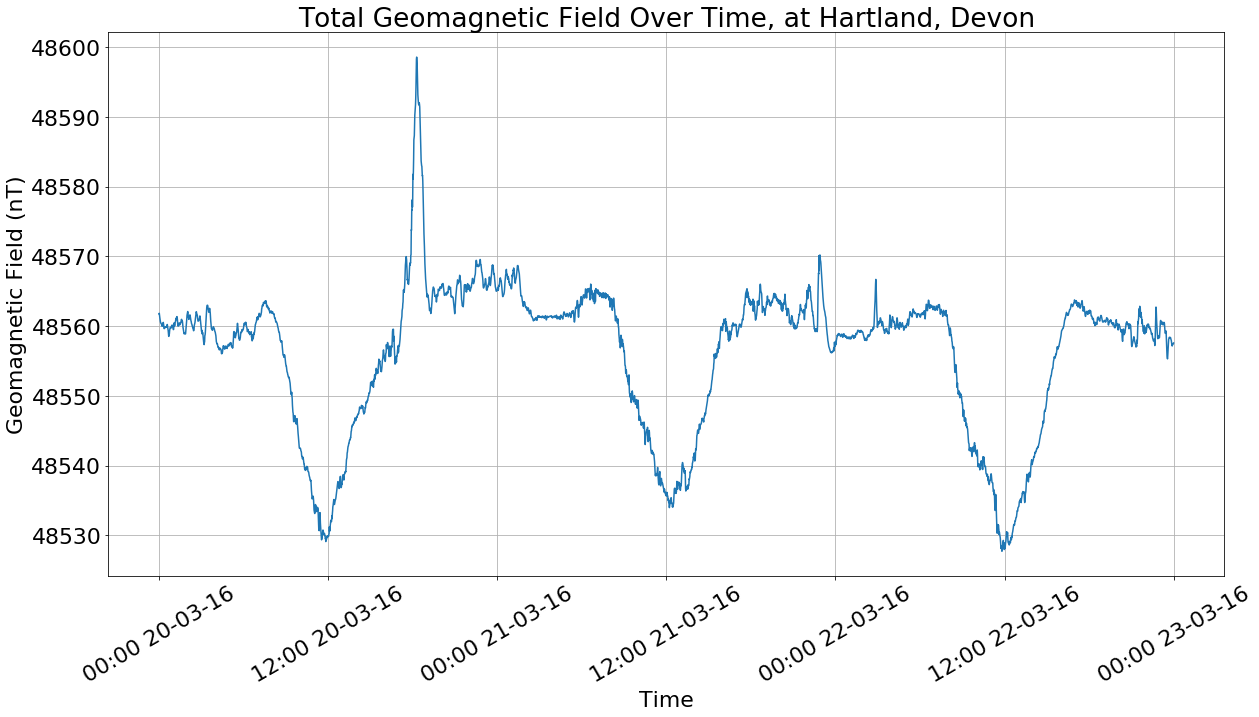

In [8]:
plt.figure(figsize=(20,10))
plt.title("Total Geomagnetic Field Over Time, at Hartland, Devon")
plt.grid()
plt.xticks(rotation=30)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M %d-%m-%y'))
plt.xlabel("Time")
plt.ylabel("Geomagnetic Field (nT)")

plt.plot(HAD_magdat["F"])